# Plot individual MI decay
1. load MI
2. plot decay for sample datasets

In [1]:
import pandas as pd
import numpy as np
from parallelspaper.config.paths import DATA_DIR, FIGURE_DIR
from parallelspaper.birdsong_datasets import MI_seqs, compress_seq, BCOL_DICT
from tqdm.autonotebook import tqdm
from parallelspaper import model_fitting as mf
import scipy.stats
import seaborn as sns
from parallelspaper.utils import save_fig

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [2]:
import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline

### Load data

In [3]:
MI_DF = pd.read_pickle((DATA_DIR / 'MI_DF/birdsong/birdsong_MI_DF_individual.pickle'))

### Plot decay

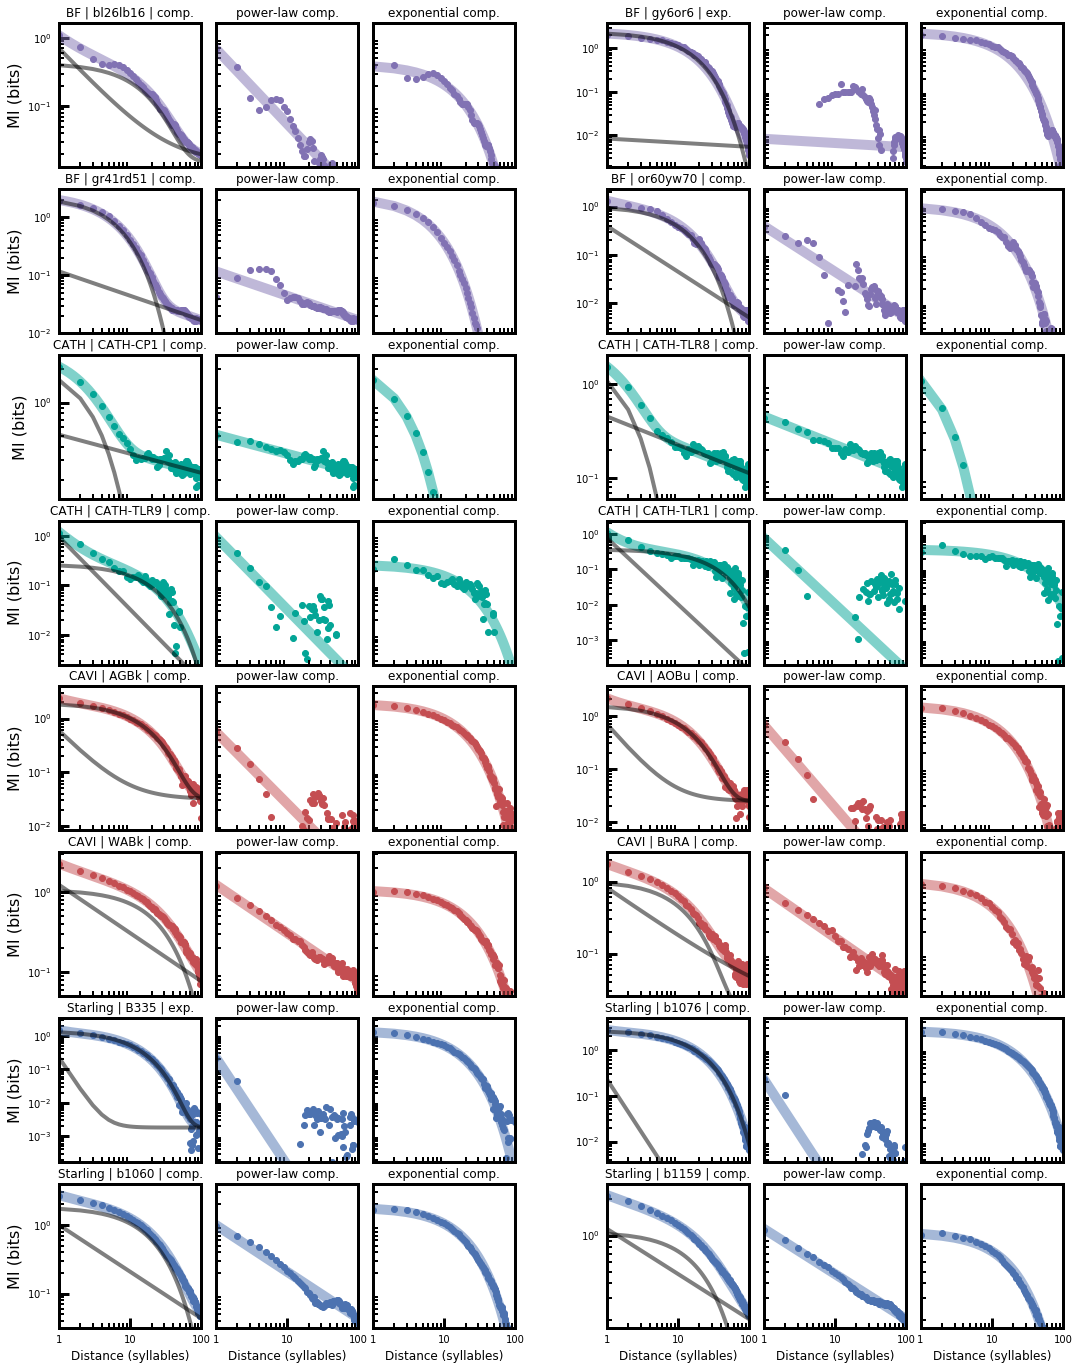

In [11]:
fontsize=16
per_species = 4
nrow = int(4 * per_species / 2)
zoom = 3
fig = plt.figure(figsize = (2*3*zoom, nrow*zoom))

outer = gridspec.GridSpec(1, 2, width_ratios = [1,1])

col0 = gridspec.GridSpecFromSubplotSpec(nrow, 3, subplot_spec = outer[0], wspace = 0.1, hspace=0.15, width_ratios = [1,1,1])
col1 = gridspec.GridSpecFromSubplotSpec(nrow, 3, subplot_spec = outer[1], wspace = 0.1, hspace=0.15, width_ratios = [1,1,1])

day_df = MI_DF[MI_DF.type =='day']
ix =0
for species in np.unique(day_df.species.values):
    species_df = day_df[day_df.species.values == species]
    species_df.index[np.argsort(species_df.AICc_exp.values - species_df.AICc_concat.values)]
    order = np.argsort(species_df.AICc_exp.values - species_df.AICc_concat.values)[::-1]
    order = np.argsort(species_df.n_elements.values)[::-1]
    for idx in species_df.index[order][:per_species]:
        row = species_df.loc[idx]
        col = col0 if ix %2 == 0 else col1
        ri = np.floor(ix/2).astype('int')
        
        ax0 = fig.add_subplot(col[ri,0])
        ax1 = fig.add_subplot(col[ri,1])
        ax2 = fig.add_subplot(col[ri,2])
        ix+=1
        if col == col0:
            ax0.set_ylabel('MI (bits)', labelpad=5, fontsize=fontsize)
        
        color = BCOL_DICT[row.species]
        MI = row.MI
        MI_shuff = row.MI_shuff
        distances=row.distances
        n_elements = row.n_elements
        exp_results = row.exp_results
        results_pow_exp = row.concat_results
        powerlaw_results = row.pow_results
        sig = MI-MI_shuff
        
        ax = ax0
        ax.scatter(distances, MI-MI_shuff, color=color)
        bfm = {'pow_exp':'comp.', 'exp':'exp.', 'pow': 'power law'}
        ax.set_title(' | '.join([row.species, row.indv, bfm[row.bestfitmodel]]))

        dist_s = np.linspace(distances[0], distances[-1], 1000)
        fit = mf.get_y(mf.pow_exp_decay, results_pow_exp, dist_s)
        ax.plot(dist_s, fit, color=color, alpha =0.5, lw=10)
        fit = mf.get_y(mf.exp_decay, results_pow_exp, distances)
        ax.plot(distances, fit,color = 'k', alpha = 0.5, lw=4)
        fit = mf.get_y(mf.powerlaw_decay, results_pow_exp, distances)
        ax.plot(distances, fit,color = 'k', alpha=0.5, lw=4)
        sig = MI-MI_shuff
        sig_lims = np.log([np.min(sig[sig>0]), np.nanmax(sig)])
        # print(sig_lims)
        sig_lims = [sig_lims[0] - (sig_lims[1]-sig_lims[0])/10,
                        sig_lims[1] + (sig_lims[1]-sig_lims[0])/10]
        
        ax.set_ylim(np.exp(sig_lims))
        ylim = ax.get_ylim()
        if col == 0:
            ax0.set_ylabel('Mutual Information (bits)', labelpad=5, fontsize=12)

        ax = ax1
        #ax = axs.flatten()[ri+(nrows*ncols)//2]
        fit = mf.get_y(mf.exp_decay, results_pow_exp, distances)
        ax.scatter(distances, MI-MI_shuff-fit, color=color)
        fit = mf.get_y(mf.powerlaw_decay, results_pow_exp, distances) 
        ax.plot(distances, 
                fit- results_pow_exp.params['intercept'].value,
               color = color, alpha =0.5, lw=10)
        ax.set_title('power-law comp.')
        ax.set_ylim(np.exp(sig_lims))
        #ax.set_yticks([])

        ax = ax2
        #ax = axs.flatten()[ri+(nrows*ncols)//2]
        fit = mf.get_y(mf.powerlaw_decay, results_pow_exp, distances)
        ax.scatter(distances, MI-MI_shuff-fit, color=color)
        fit = mf.get_y(mf.exp_decay, results_pow_exp, distances) 
        ax.plot(distances, 
                fit - results_pow_exp.params['intercept'].value,
               color = color, alpha =0.5, lw=10)
        ax.set_title('exponential comp.')
        #ax.set_ylim(np.exp(sig_lims))
        
        for axi, ax in enumerate([ax0,ax1, ax2]):    
            ax.set_ylim(np.exp(sig_lims))
            ax.set_xscale( "log" , basex=10)
            ax.set_yscale( "log" , basey=10)
            ax.tick_params(axis='both', labelsize=10, pad=7)
            for axis in ['top','bottom','left','right']:
                ax.spines[axis].set_linewidth(3)
                ax.spines[axis].set_color('k')
            ax.grid(False)
            ax.tick_params(which='both', direction='in')
            ax.tick_params(which='major', length=10, width =3)
            ax.tick_params(which='minor', length=5, width =2)
            ax.set_xlim([1,distances[-1]])
            #ax.set_ylim([-1e-4,1e-4])
            ax.set_xscale( "log" , basex=10)
            if ri == nrow-1:
                ax.set_xticks([1,10,100])
                ax.set_xticklabels(['1','10','100'])
            else:
                ax.set_xticks([])

            if ri == nrow-1:
                ax.set_xlabel('Distance (syllables)', labelpad=5, fontsize=12)

        ax1.set_yticks([])
        ax2.set_yticks([])        


save_fig(FIGURE_DIR/'largest_birds')
plt.show()
